In [1]:
import pandas as pd
import numpy as np
from pm4py.objects.conversion.log import converter as log_converter 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.objects.petri_net.exporter import exporter as pnml_exporter

In [2]:
eventlog = pd.read_csv ('event_log.csv', sep=";")
pm4pylog = pd.read_csv ('event_log.csv', sep=";")
pm4pylog['ts']= pd.to_datetime(pm4pylog['ts'])

C:\Users\jofr\AppData\Local\Programs\Python\Python38-32\lib\site-packages\dateutil\parser\_parser.py:1213: UnknownTimezoneWarning: tzname CET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [3]:
pm4pylog["event"] = pm4pylog["resource"] + "." + pm4pylog["event"] 
eventlog["event"] = eventlog["resource"] + "." + eventlog["event"] 

In [4]:
pm4pylog.head()

,ts,id,resource,event
0,2022-02-24 00:01:15,448,system,system.new_order
1,2022-02-24 00:01:15,448,system,system.direct_to_line2
2,2022-02-24 00:01:15,448,agv,agv.transport_to_cell2_buffer
3,2022-02-24 00:05:06,448,cell2_buffer,cell2_buffer.enter_cell2
4,2022-02-24 00:05:06,448,cell2,cell2.cell2_operation


In [5]:
statelog = pd.read_csv ('state_log.csv', sep=";")

In [6]:
pm4pylog.rename(columns={'ts': 'time:timestamp', 
'id': 'case:concept:name', 'event': 'concept:name', 'resource': 'org:resource'}, inplace=True)
log = log_converter.apply(pm4pylog)

In [7]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
dfg = dfg_discovery.apply(log)
dfg

Counter({('system.new_order', 'system.direct_to_line2'): 1233,
         ('system.direct_to_line2', 'agv.transport_to_cell2_buffer'): 1151,
         ('agv.transport_to_cell2_buffer', 'cell2_buffer.enter_cell2'): 1141,
         ('cell2_buffer.enter_cell2', 'cell2.cell2_operation'): 1141,
         ('cell2.cell2_operation', 'system.order_completed'): 1141,
         ('system.new_order', 'system.direct_to_line1'): 1278,
         ('system.direct_to_line1', 'agv.transport_to_cell1_buffer'): 1197,
         ('agv.transport_to_cell1_buffer', 'cell1_buffer.enter_cell1'): 1197,
         ('cell1_buffer.enter_cell1', 'cell1.cell1_operation'): 1197,
         ('cell1.cell1_operation', 'system.order_completed'): 1197})

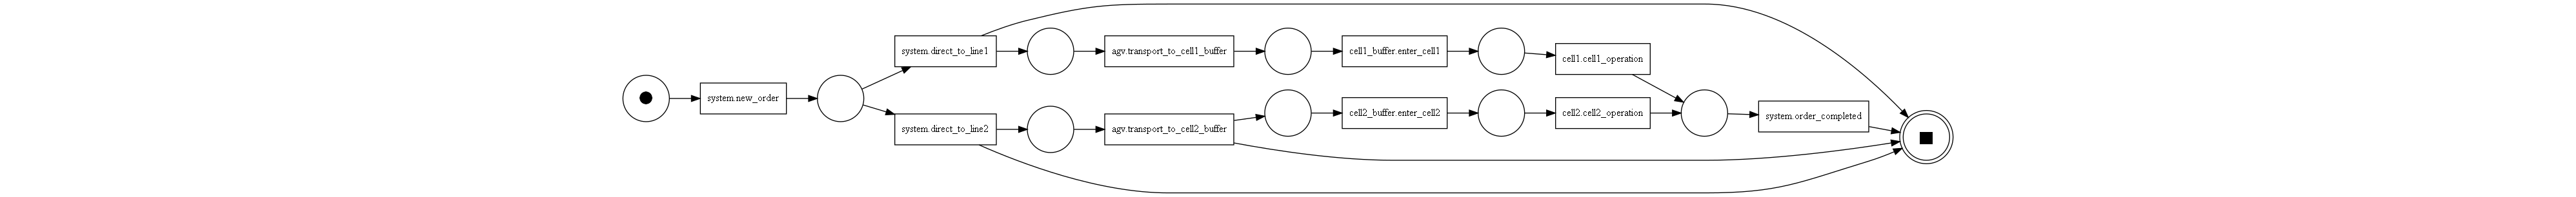

In [8]:

from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, im, fm = alpha_miner.apply(log)

from pm4py.visualization.petri_net import visualizer as pn_visualizer
gviz = pn_visualizer.apply(net, im, fm)
gviz.attr(margin = "10,0.01")
pn_visualizer.view(gviz)

Remove arcs from unfinished orders

In [9]:
arcs = list(net.arcs)
for arc in arcs:
    if "(p)end" in str(arc) and "order_completed" not in str(arc):
        net.arcs.remove(arcs[arcs.index(arc)]) 

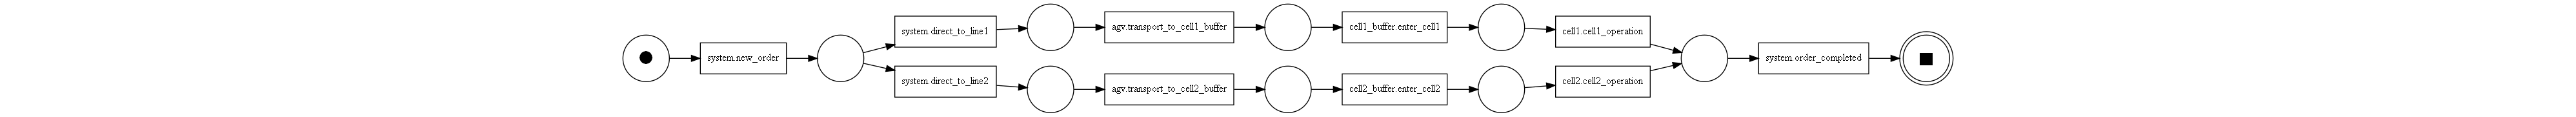

In [10]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer
gviz = pn_visualizer.apply(net, im, fm)
gviz.attr(margin = "10,0.01")
pn_visualizer.view(gviz)

replaying log with TBR, completed variants :: 100%|██████████| 5/5 [00:00<00:00, 135.14it/s]


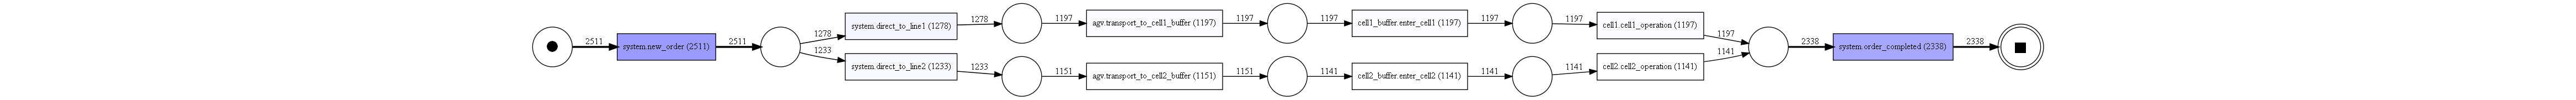

In [11]:
gviz = pn_visualizer.apply(net, im, fm, variant=pn_visualizer.Variants.FREQUENCY, log=log)
gviz.attr(margin = "10,0.01")
pn_visualizer.view(gviz)

Determine Immediate transitions

In [12]:
# Retrieve resources from state log
resources = list(statelog["resource"].unique())
resources

['agv', 'cell2', 'cell1']

In [13]:
# determine immediate transitions
for transition in iter(net.transitions):
    resource = str(transition).split(".")[0]
    if resource not in resources:
        transition.label = (str(transition) + ".(i)")
    else: transition.label = (str(transition) + ".(t)")


Transition firing frequencies

In [14]:
from collections import Counter
occurrence_count = []

for df in dfg.most_common():
    occurrence_count.append(df[0][0])

occurrence_count = Counter(occurrence_count)
xor_prev_transitions = [word for word, occurrences in occurrence_count.items() if occurrences > 1]

In [15]:
xor_prev_transitions

['system.new_order']

In [16]:
for pt in xor_prev_transitions:
    transition_frequencies = {}
    for df in dfg.most_common():
        if pt in df[0][0]:
            transition_frequencies[df[0]] = df[1]
    
    total_count = sum(transition_frequencies.values())

    for key in transition_frequencies:
        transition_frequencies[key] = total_count

    for transition in iter(net.transitions):
        for key in transition_frequencies:
            if key[0] in str(transition) and not "i)." in str(transition):
                transition.label = (str(transition) + "."+ (str(transition_frequencies[key])))

In [17]:
occurrence_count = []

for df in dfg.most_common():
    occurrence_count.append(df[0][1])

occurrence_count = Counter(occurrence_count)
xor_subseq_transitions = [word for word, occurrences in occurrence_count.items() if occurrences > 1]

In [18]:
xor_subseq_transitions

['system.order_completed']

In [19]:
for pt in xor_subseq_transitions:
    transition_frequencies = {}
    for df in dfg.most_common():
        if pt in df[0][1]:
            transition_frequencies[df[0]] = df[1]
    
    total_count = sum(transition_frequencies.values())

    for key in transition_frequencies:
        transition_frequencies[key] = total_count

    for transition in iter(net.transitions):
        for key in transition_frequencies:
            if key[1] in str(transition) and not "i)." in str(transition):
                transition.label = (str(transition) + "."+ (str(transition_frequencies[key])))

In [20]:
for transition in iter(net.transitions):
    for df in dfg.most_common():
        if df[0][1] in str(transition) and ")." not in str(transition):
            transition.label = (str(transition) + "."+ (str(df[1])))
        

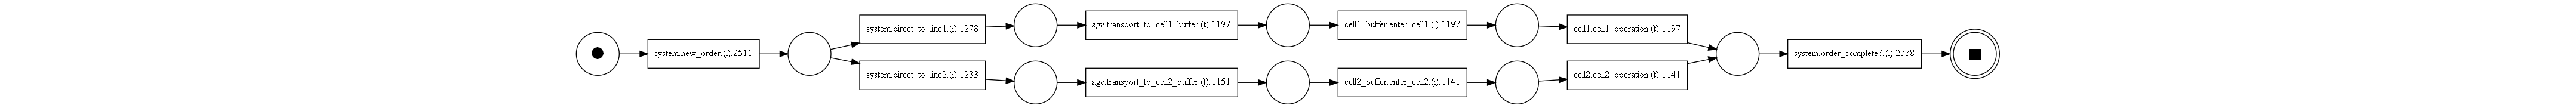

In [21]:
gviz = pn_visualizer.apply(net, im, fm,)
gviz.attr(margin = "10,0.01")
pn_visualizer.view(gviz)

Estimation of timed transition firing times


In [22]:
timed_transitions = []

for transition in iter(net.transitions):
    if "(t)" in str(transition):
        timed_transitions.append(str(transition).partition("(")[0][:-1])

In [23]:
btimes = {k: [] for k in timed_transitions}
itimes = {k: [] for k in timed_transitions}
otimes = {k: [] for k in timed_transitions}
transition_distributions = {k: () for k in timed_transitions}
transition_distributions

{'cell2.cell2_operation': (),
 'agv.transport_to_cell2_buffer': (),
 'agv.transport_to_cell1_buffer': (),
 'cell1.cell1_operation': ()}

In [24]:
for transition in otimes:
    print(transition)
    el = eventlog.loc[eventlog["event"] == transition]
    resource = transition.split(".")[0]
    sl = statelog.loc[statelog["resource"] == resource]

    sl = sl.reset_index(drop = True)
    idx_failure = sl[sl.state == "failure"].index
    sl = sl.drop(idx_failure)   #drop "failure"
    try:
        sl = sl.drop(idx_failure+1) #drop idle after failure
    except:
        pass

    sl_wo_idle = sl.loc[sl["state"]=="busy"]
    elsl = pd.merge(el,sl_wo_idle,how="inner")
    elsl = pd.merge(elsl,sl,how="right")
    if elsl.state.iloc[-1] == "busy": elsl = elsl[:-1]

    btimes[transition] = elsl.loc[elsl[elsl.event.notnull()].index,["ts"]]["ts"].tolist()
    itimes[transition] = elsl.loc[elsl[elsl.event.notnull()].index+1,["ts"]]["ts"].tolist()

    otimes[transition] = [x2 - x1 for (x2, x1) in zip(pd.to_datetime(itimes[transition]), pd.to_datetime(btimes[transition]))]
    


cell2.cell2_operation


C:\Users\jofr\AppData\Local\Programs\Python\Python38-32\lib\site-packages\dateutil\parser\_parser.py:1213: UnknownTimezoneWarning: tzname CET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


agv.transport_to_cell2_buffer
agv.transport_to_cell1_buffer
cell1.cell1_operation


In [25]:
import seaborn as sns
from fitter import Fitter

In [26]:
from itertools import islice

def downsample_to_proportion(rows, proportion=1):
    return list(islice(rows, 0, len(rows), int(1/proportion)))

In [27]:
for transition in otimes:
    print(transition)
    data = [round(i.total_seconds()/60,2) for i in otimes[transition]]
    data = downsample_to_proportion(data, 0.3)
    f = Fitter(data, distributions=["norm","lognorm"])
    f.fit()
    transition_distributions[transition] = f.get_best(method = 'sumsquare_error')

cell2.cell2_operation
agv.transport_to_cell2_buffer
agv.transport_to_cell1_buffer
cell1.cell1_operation


In [28]:
for resource in transition_distributions:
    print(resource)
    dist, params = list(transition_distributions[resource].items())[0]
    params = list(params.values())
    params = [round(param, 1) for param in params]
    params = ','.join(str(param) for param in params)
    for transition in iter(net.transitions):
        if resource in str(transition):
            transition.label = (str(transition) + "." + dist + "(" + params + ")")

cell2.cell2_operation
agv.transport_to_cell2_buffer
agv.transport_to_cell1_buffer
cell1.cell1_operation


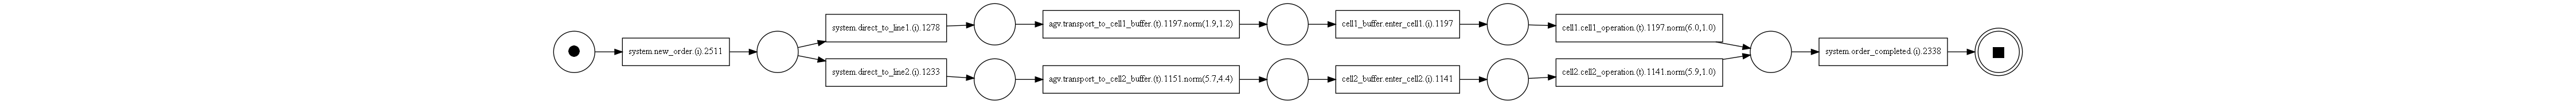

In [29]:
gviz = pn_visualizer.apply(net, im, fm,)
gviz.attr(margin = "10,0.01")
pn_visualizer.view(gviz)

Detect Buffer Sizes

In [30]:
# Retrieve assets from event log
assets = list(eventlog["resource"].unique())
assets_with_buffer = [k for k in assets if 'buffer' in k]
print(assets_with_buffer)
assets_with_buffer = [k.split("_", 1)[0] for k in assets_with_buffer]
print(assets_with_buffer)


['cell2_buffer', 'cell1_buffer']
['cell2', 'cell1']


In [31]:
buffer_sizes = {}

for asset in assets_with_buffer:
    current_bs = 0 
    bs = []

    for event in eventlog["event"]:
        if "transport_to_" + asset + "_buffer" in event:
            current_bs += 1
            bs.append(current_bs)
        if "enter_" + asset in event:
            current_bs -= 1
    buffer_sizes[asset] = max(bs)

print(buffer_sizes)


{'cell2': 10, 'cell1': 10}


In [32]:
net.places

{({'agv.transport_to_cell1_buffer'}, {'cell1_buffer.enter_cell1'}),
 ({'agv.transport_to_cell2_buffer'}, {'cell2_buffer.enter_cell2'}),
 ({'cell1_buffer.enter_cell1'}, {'cell1.cell1_operation'}),
 ({'cell2.cell2_operation', 'cell1.cell1_operation'}, {'system.order_completed'}),
 ({'cell2_buffer.enter_cell2'}, {'cell2.cell2_operation'}),
 ({'system.direct_to_line1'}, {'agv.transport_to_cell1_buffer'}),
 ({'system.direct_to_line2'}, {'agv.transport_to_cell2_buffer'}),
 ({'system.new_order'}, {'system.direct_to_line1', 'system.direct_to_line2'}),
 end,
 start}

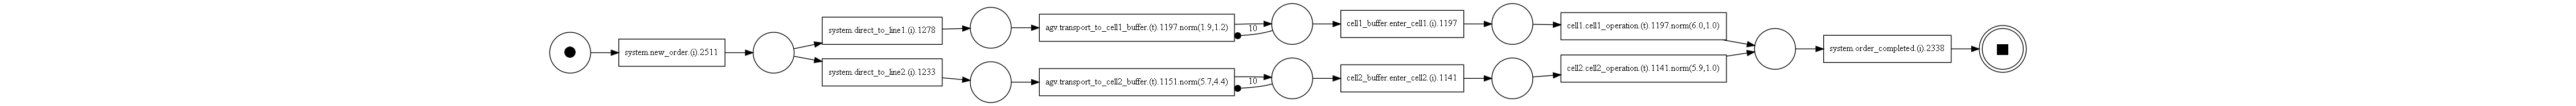

In [33]:
from pm4py.objects.petri_net.utils import petri_utils

places = list(net.places)
transitions = list(net.transitions)

for place in places:
    if "enter_cell" in str(place).partition("},")[-1]:
        place_for_inhib = place
        trans_for_inhib_str = str(place).partition(",")[0].partition("""'""")[2].partition("""'""")[0]
        trans_for_inhib = [k for k in transitions if trans_for_inhib_str in str(k)]
        trans_for_inhib[0]
        
        inhib_arc = petri_utils.add_arc_from_to(place_for_inhib, trans_for_inhib[0], net)
        inhib_arc.properties["arctype"] = "inhibitor"
        inhib_arc.weight = buffer_sizes[str(place_for_inhib).partition(",")[2].partition("""'""")[2].partition("""'""")[0].partition("_")[2].partition(".")[2].partition("_")[2]]
        net.arcs.add(inhib_arc)
    	
gviz = pn_visualizer.apply(net, im, fm,)
gviz.attr(margin = "10,0.01")
pn_visualizer.view(gviz)   



Detect Cell Capacity

In [34]:
list(eventlog["event"].unique())

['system.new_order',
 'system.direct_to_line2',
 'agv.transport_to_cell2_buffer',
 'cell2_buffer.enter_cell2',
 'cell2.cell2_operation',
 'system.direct_to_line1',
 'agv.transport_to_cell1_buffer',
 'cell1_buffer.enter_cell1',
 'cell1.cell1_operation',
 'system.order_completed']

In [35]:
# Retrieve assets from state log
assets = list(eventlog["event"].unique())
assets_with_operation = [k for k in assets if 'operation' in k]
print(assets_with_operation)
assets_with_operation = [k.split("_", 1)[0] for k in assets_with_operation]
print(assets_with_operation)

['cell2.cell2_operation', 'cell1.cell1_operation']
['cell2.cell2', 'cell1.cell1']


In [36]:
capacities = {}

for asset in assets_with_operation:
    current_cap = 0 
    cap = []

    for event in eventlog["event"]:
        if asset + "_operation" in event:
            current_cap += 1
            cap.append(current_cap)
        if asset + "_operation" in event:
            current_cap -= 1
    capacities[asset] = max(cap)

print(capacities)

{'cell2.cell2': 1, 'cell1.cell1': 1}


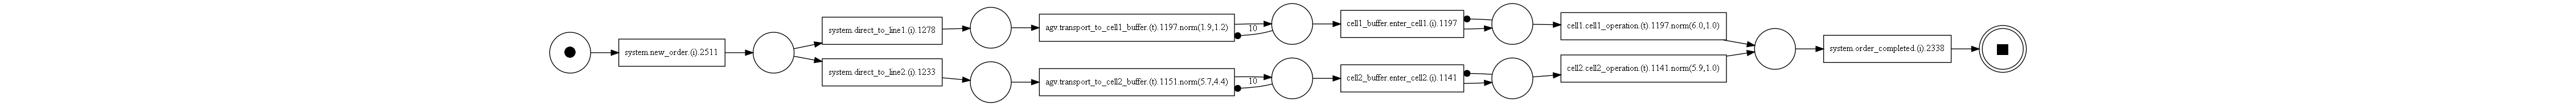

In [37]:
places = list(net.places)
transitions = list(net.transitions)

for place in places:
    #print(str(place))
    if "_operation'})" in str(place):
        place_for_inhib = place
        trans_for_inhib_str = str(place).partition(",")[0].partition("""'""")[2].partition("""'""")[0]
        trans_for_inhib = [k for k in transitions if trans_for_inhib_str in str(k)]
        trans_for_inhib[0]
        
        inhib_arc = petri_utils.add_arc_from_to(place_for_inhib, trans_for_inhib[0], net)
        inhib_arc.properties["arctype"] = "inhibitor"
        inhib_arc.weight = capacities[str(place_for_inhib).partition(",")[2].partition("""'""")[2].partition("""'""")[0].partition("_")[0]]
        net.arcs.add(inhib_arc)
    	
gviz = pn_visualizer.apply(net, im, fm)
gviz.attr(margin = "10,0.01")
pn_visualizer.view(gviz)

Reliability Loops

In [38]:
from pm4py.objects.petri_net.obj import PetriNet, Marking
from pm4py.objects.petri_net.utils import petri_utils
from pm4py.objects.petri_net import properties as petri_properties

In [39]:
# Retrieve resources from state log
statelog = pd.read_csv ('state_log.csv', sep=";", parse_dates=['ts'])
resources = list(statelog["resource"].unique())
resources

['agv', 'cell2', 'cell1']

In [40]:
# Create failure loops for each resource and connect them to process flow model

for resource in resources:

    p_ok = PetriNet.Place(str(resource) + "_ok")
    p_failed = PetriNet.Place(str(resource) + "_failed")

    t_repair = PetriNet.Transition(str(resource) + ".repair", str(resource) + ".repair")
    t_fail = PetriNet.Transition(str(resource) + ".fail", str(resource) + ".fail")
    
    net.places.add(p_ok)
    net.places.add(p_failed)
    net.transitions.add(t_repair)
    net.transitions.add(t_fail)

    im[p_ok] = 1

    petri_utils.add_arc_from_to(p_ok, t_fail, net)
    petri_utils.add_arc_from_to(t_fail, p_failed, net)
    petri_utils.add_arc_from_to(p_failed, t_repair, net)
    petri_utils.add_arc_from_to(t_repair, p_ok, net)

    it = iter(net.transitions)
    while True:
        x = next(it, None)
        if not x:
            break
        if str(x).partition(".")[0] == resource and "repair" not in str(x) and "fail" not in str(x):
            hit = x
            inhib_arc = petri_utils.add_arc_from_to(p_failed, hit, net)
            inhib_arc.properties["arctype"] = "inhibitor"

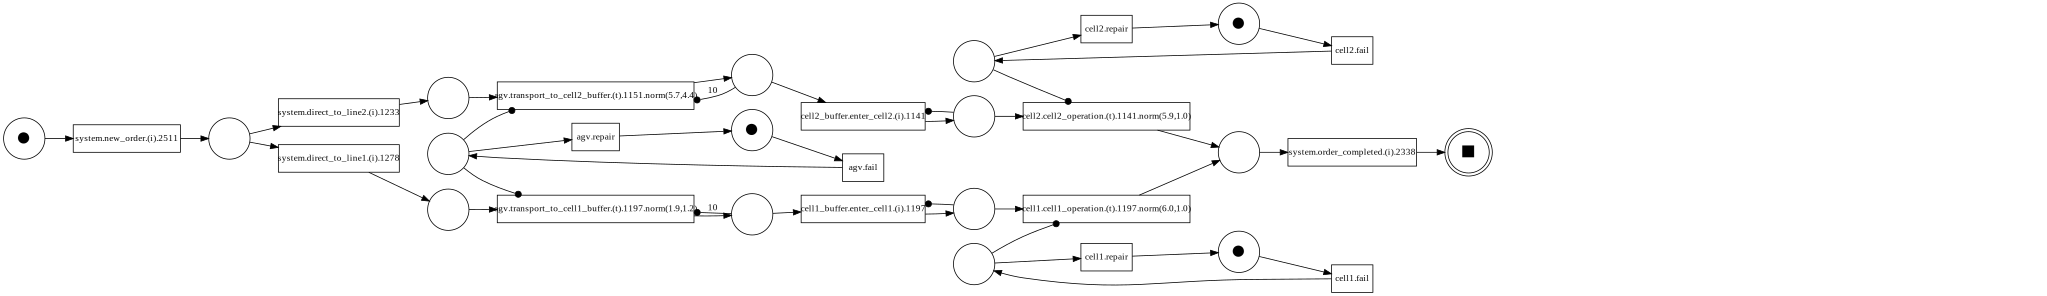

In [41]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer

gviz = pn_visualizer.apply(net, im, fm)
#gviz.graph_attr["rankdir"] = "TB"
gviz.attr(margin = "10,0.01")

gviz

In [42]:
pnml_exporter.apply(net, im, "petri.pnml")

Repair and Failure Rate calc

In [43]:
ftimes = {k: [] for k in resources}
itimes = {k: [] for k in resources}
rtimes = {k: [] for k in resources}
failure_distributions = {k: () for k in resources}
repair_distributions =  {k: () for k in resources}
ftimes

{'agv': [], 'cell2': [], 'cell1': []}

In [44]:
start_time = statelog.ts[0]

In [45]:
def get_failure_times(failures, repairs, start_time):
    failure_list = []
    failure_list.append(failures[0] - start_time)
    for i in range(len(failures)-1):
        failure_time = failures[i+1] - repairs[i]
        failure_list.append(failure_time)
    return failure_list

In [46]:
for resource in rtimes:
    resource_failure_idle_times = statelog.loc[(statelog["resource"] == resource) & ((statelog["state"] == "failure") | (statelog["state"] == "idle")) ]
    resource_failure_idle_times = resource_failure_idle_times.reset_index(drop= True)
    failure_idx = resource_failure_idle_times.index[resource_failure_idle_times.state == "failure"] 
    failure_idx = failure_idx[:-1] # drop last "failure" in case there is no repair afterwards
    failure_times = resource_failure_idle_times.loc[failure_idx]
    idle_times = resource_failure_idle_times.loc[failure_idx + 1]
    ftimes[resource] = failure_times.ts.tolist()
    itimes[resource] = idle_times.ts.tolist()
    rtimes[resource] = [x2 - x1 for (x2, x1) in zip(pd.to_datetime(itimes[resource]), pd.to_datetime(ftimes[resource]))]
    ftimes[resource] = get_failure_times(ftimes[resource], itimes[resource], start_time)

In [47]:
for transition in failure_distributions:
    print(transition)
    data = [round(i.total_seconds()/60,2) for i in ftimes[transition]]
    data = downsample_to_proportion(data, 0.8)
    f = Fitter(data, distributions=["lognorm","expon","weibull_min"])
    f.fit()
    failure_distributions[transition] = f.get_best(method = 'sumsquare_error')

agv
cell2
cell1


In [48]:
for transition in repair_distributions:
    print(transition)
    data = [round(i.total_seconds()/60,2) for i in rtimes[transition]]
    data = downsample_to_proportion(data, 0.8)
    f = Fitter(data, distributions=["norm","lognorm","expon"])
    f.fit()
    repair_distributions[transition] = f.get_best(method = 'sumsquare_error')

agv
cell2
cell1


Add to Petri net

In [49]:
for resource in resources:    
    it = iter(net.transitions)
    while True:
        x = next(it, None)
        if not x:
            break
        if str(x) == str(resource) + ".fail":
            print(str(x))
            dist, params = list(failure_distributions[resource].items())[0]
            params = list(params.values())
            params = [round(param, 1) for param in params]
            params = ','.join(str(param) for param in params)
            x.label = str(x) + "." + dist + "(" + params + ")"
        
for resource in resources:    
    it = iter(net.transitions)
    while True:
        x = next(it, None)
        if not x:
            break
        if str(x) == str(resource) + ".repair":
            dist, params = list(repair_distributions[resource].items())[0]
            params = list(params.values())
            params = [round(param, 1) for param in params]
            params = ','.join(str(param) for param in params)
            x.label = str(x) + "." + dist + "(" + params + ")"
        
        
            

agv.fail
cell2.fail
cell1.fail


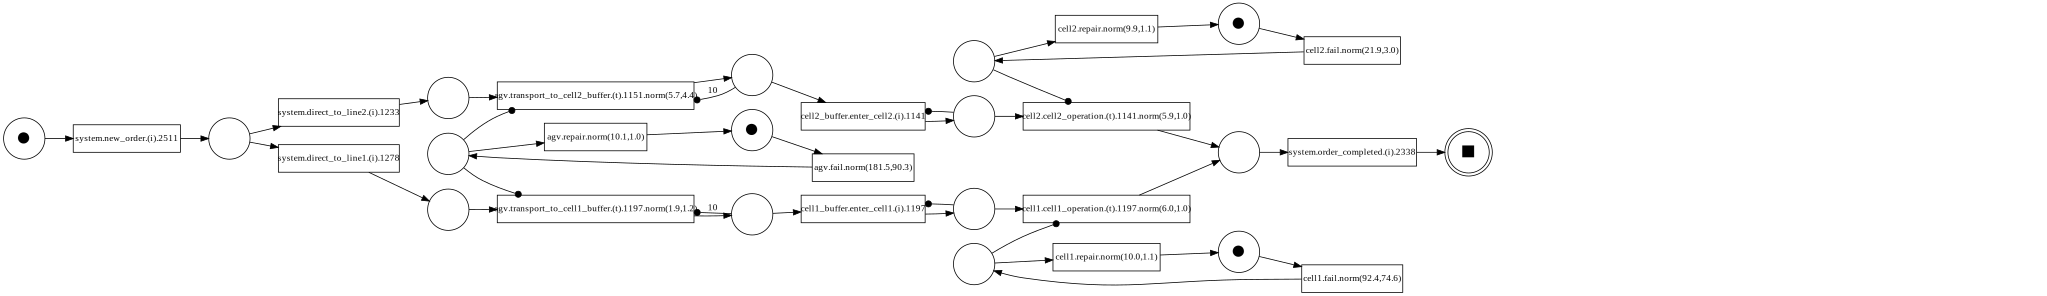

In [50]:
gviz = pn_visualizer.apply(net, im, fm)
gviz.attr(margin = "10,0.01")
#gviz.graph_attr["rankdir"] = "TB"
#pn_visualizer.view(gviz)
gviz

In [51]:
pn_visualizer.save(gviz, "gviz.dot")

In [ ]:
pnml_exporter.apply(net, im, "petri.pnml")